In [1]:
from __future__ import print_function, absolute_import
import numpy as np
from scipy import signal, fft, io
from matplotlib import pyplot as plt

In [2]:
data = io.loadmat('../data/eth/ID1/Sz1.mat')

In [3]:
dt = np.arange(0, len(data['EEG'])/512, 1/512)

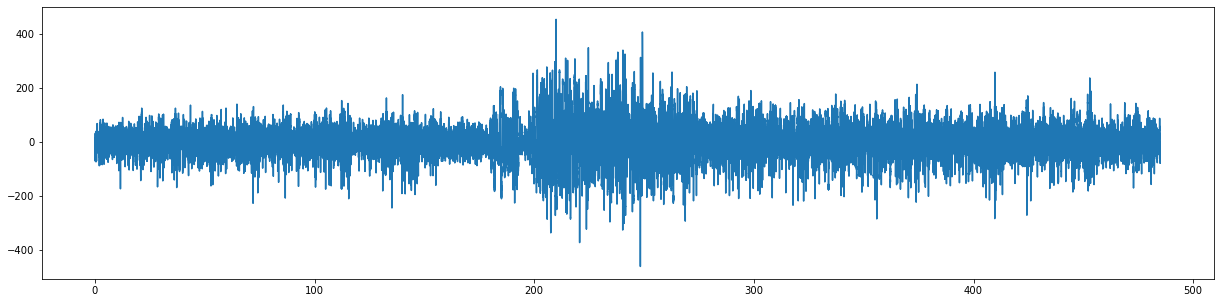

In [4]:
plt.figure(figsize=(21,5))
plt.plot(dt, data['EEG'][:,15])

## STFT analysis begins here

In [5]:
nperseg=500*512//1000      # in ms
noverlap = 3*nperseg//4
f, t, ds = signal.stft(data['EEG'][:,0], fs=512, nperseg=nperseg, noverlap=noverlap, detrend='constant')

In [6]:
500*512//1000

256

In [7]:
idx = np.squeeze(np.where(f>=200))[0]
f = f[:idx]
ds = np.abs(ds[:idx,:])

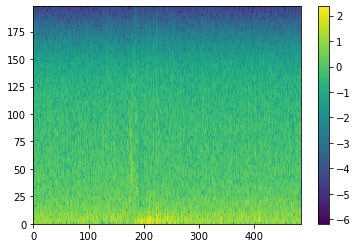

In [8]:
plt.pcolormesh(t, f, np.log10(ds), shading='nearest'); plt.colorbar();

In [9]:
from sklearn.preprocessing import normalize

In [10]:
dtft_norm = normalize(ds, norm='l2', copy=True, axis=0)

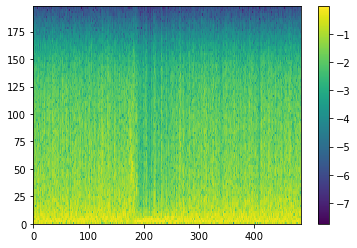

In [11]:
plt.pcolormesh(t,f,np.log10(dtft_norm), shading='nearest'); plt.colorbar();

In [12]:
mean_ds = np.mean(dtft_norm, axis=1)

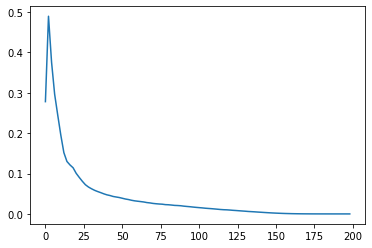

In [13]:
plt.plot(f, mean_ds)

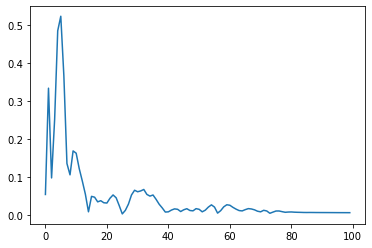

In [14]:
plt.plot(dtft_norm[:,-1])

In [15]:
ds_mc = ((dtft_norm.T - mean_ds).T).copy()

<ipython-input-16-42b6aa1973e5>:1: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(t,f,np.log10(ds_mc), shading='nearest'); plt.colorbar();


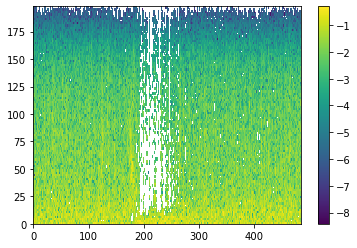

In [16]:
plt.pcolormesh(t,f,np.log10(ds_mc), shading='nearest'); plt.colorbar();

## SVD of DTFT

In [17]:
u1, s1, vh1 = np.linalg.svd(ds_mc, full_matrices=False)

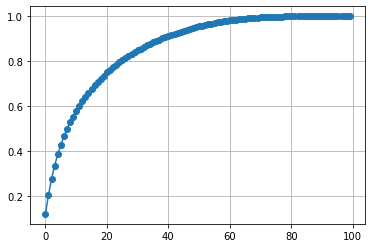

In [18]:
plt.plot(np.cumsum(s1)/np.sum(s1), 'o-'); plt.grid();

(0.001, 1)

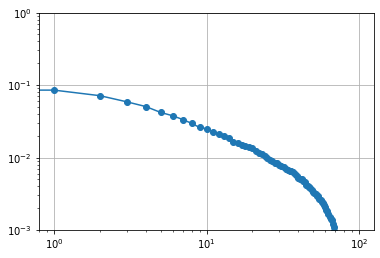

In [19]:
plt.loglog(s1/sum(s1), 'o-'); plt.grid(); plt.ylim([0.001, 1])

In [20]:
ncomps = np.squeeze(np.where(np.cumsum(s1)/np.sum(s1) >= 0.8))[0]
print(ncomps)

25


In [21]:
ds_approx = u1[:,:10] @ np.diag(s1[:10]) @ vh1[:10,:]

<ipython-input-22-de90de6a7680>:2: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(t, f, np.log10((ds_approx.T + mean_ds.T).T), shading='nearest')


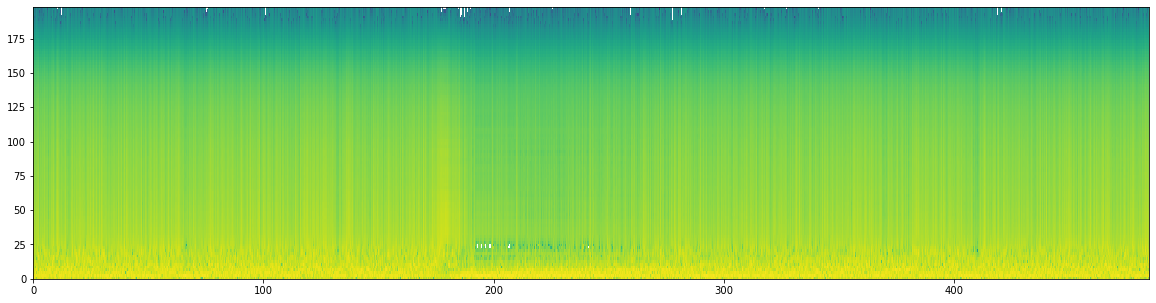

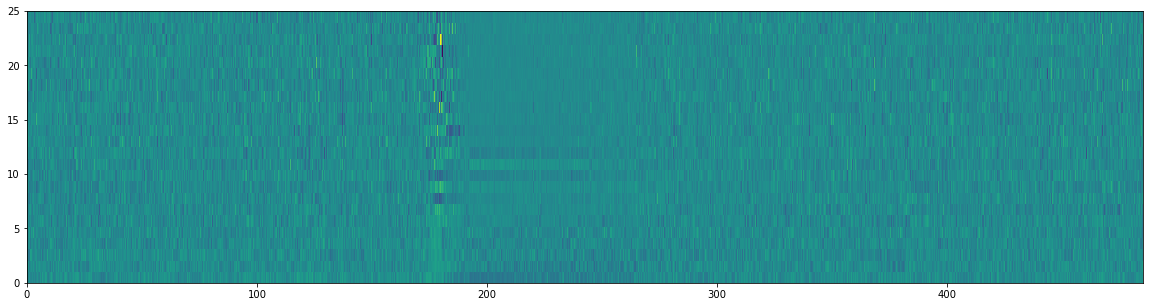

In [22]:
plt.figure(figsize=(20,5))
plt.pcolormesh(t, f, np.log10((ds_approx.T + mean_ds.T).T), shading='nearest')
plt.figure(figsize=(20,5))
plt.pcolormesh(t, np.linspace(0, ncomps, ncomps), vh1[:ncomps,:])

## GMM fit to the data

In [23]:
from sklearn.mixture import BayesianGaussianMixture

In [24]:
nevents=100
bgm = BayesianGaussianMixture(
    n_components=nevents,
    n_init=20,
    init_params='kmeans',
    max_iter=10000,
    covariance_type='diag',
    )
ncomps=10
%time bgm.fit(vh1[:ncomps,:].T)

CPU times: user 15min 54s, sys: 1min 43s, total: 17min 37s
Wall time: 3min 41s


BayesianGaussianMixture(covariance_type='diag', max_iter=10000,
                        n_components=100, n_init=20)

### Arrange events and IDs based on frequency of occurence

In [25]:
res = bgm.predict(vh1[:ncomps,:].T)
means = (bgm.means_).T
ids, counts = np.unique(res, return_counts=True)
# counts = counts/np.sum(counts)
nevts = len(np.unique(ids))
print("Num evts: {}".format(len(np.unique(ids))))

Num evts: 14


In [26]:
means = means[:,ids]
idx = np.argsort(counts)[::-1]
means = means[:,idx]
counts = counts[idx]
ids = ids[idx]

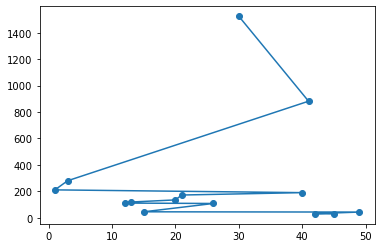

In [27]:
plt.plot(ids, counts, 'o-')

### Rewrite event IDs based on event frequency

In [28]:
lab_ids = np.arange(len(ids))

l = np.zeros(res.shape)

for i, j in zip(ids, range(len(ids))):
    tmp_idx = np.where(res==i)
    l[tmp_idx] = int(lab_ids[j])

res = l.astype(int)

## Filtering similar events

In [29]:
dots = np.zeros((means.shape[1], means.shape[1]))
mean_norm = normalize(means, norm='l2', axis=0, copy=True)
for i in range(means.shape[1]):
    for j in range(means.shape[1]):
        dots[i,j] = np.dot(mean_norm[:,i], mean_norm[:,j])

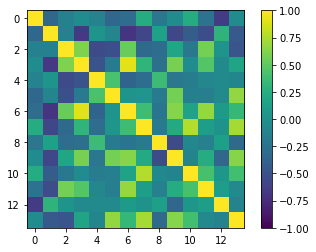

In [30]:
plt.imshow(dots); plt.colorbar(); plt.clim([-1,1])

In [31]:
evt_psd_mc = ((u1[:,:ncomps] @ np.diag(s1[:ncomps]) @ means).T + mean_ds.T).T
evt_psd_mc = normalize(evt_psd_mc, axis=0)

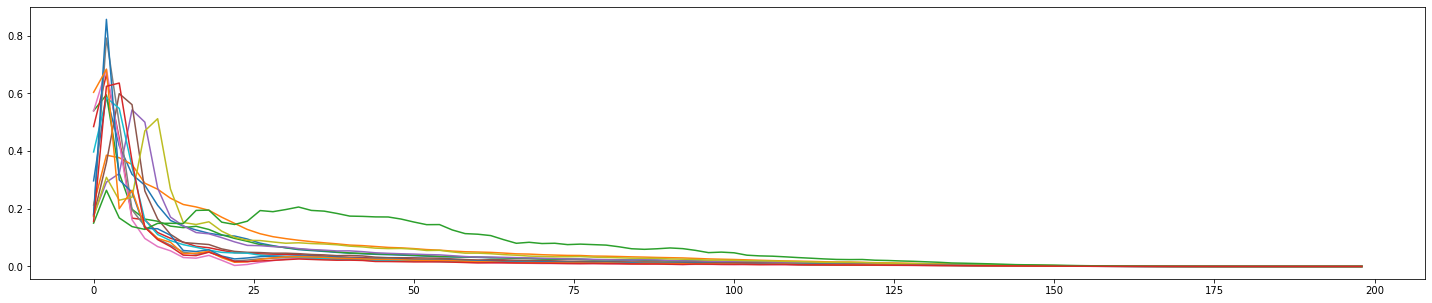

In [32]:
plt.figure(figsize=(25,5));
plt.plot(f, normalize(evt_psd_mc, axis=0, norm="l2"));

## SVD decomposition of PSD matrix

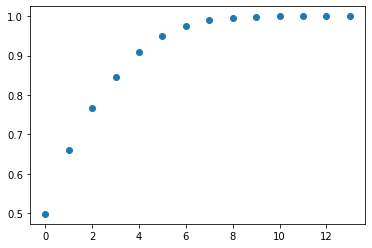

In [151]:
U, D, Vt = np.linalg.svd(evt_psd_mc)
plt.plot(np.cumsum(D)/np.sum(D),'o')

In [33]:
U, D, _ = np.linalg.svd(evt_psd_mc.T @ evt_psd_mc)

In [34]:
np.isclose(D,0)

array([False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True])

In [35]:
len(np.where(np.isclose(D,0)))

1

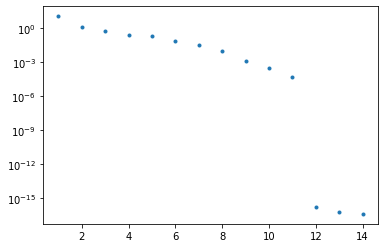

In [36]:
plt.semilogy(np.arange(1,len(D)+1), D, '.')

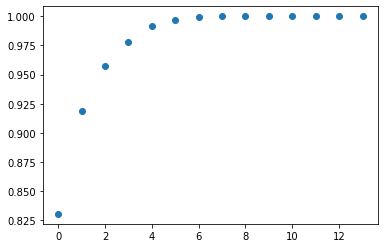

In [145]:
plt.plot(np.cumsum(D)/np.sum(D),'o')

In [39]:
dD = np.diff(np.log(D))
nclus_pds = np.where(dD==min(dD))[0][0] +1
print(f"Optimal number of clusters = {nclus_pds}")

Optimal number of clusters = 11


In [59]:
from sklearn.cluster import 

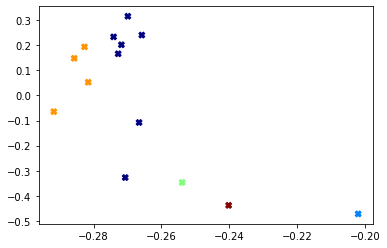

In [165]:
sc = KMeans(n_clusters=5).fit(U[:,:1])
plt.scatter(U[:,0], U[:,1], c=sc.labels_, cmap='jet', marker='X')

In [126]:
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(U[:,:2], n_neighbors=3, mode='distance')
A.toarray()
print(A)

  (0, 5)	0.05000030117743255
  (0, 2)	0.11763470753793008
  (0, 9)	0.21273487830674456
  (1, 4)	0.025683950557907433
  (1, 8)	0.11484607536606573
  (1, 12)	0.16029198658086596
  (2, 9)	0.09554344014530615
  (2, 13)	0.11376613551946552
  (2, 0)	0.11763470753793008
  (3, 10)	0.01368154639691147
  (3, 13)	0.02935174222816119
  (3, 7)	0.040730500435222715
  (4, 1)	0.025683950557907433
  (4, 8)	0.09231071667284554
  (4, 12)	0.13570946791950028
  (5, 0)	0.05000030117743255
  (5, 2)	0.1611176668224191
  (5, 1)	0.21937622064105844
  (6, 11)	0.07514714111961575
  (6, 7)	0.0822002314337084
  (6, 10)	0.11364097259689833
  (7, 11)	0.010910600264921447
  (7, 10)	0.031617201226915276
  (7, 3)	0.040730500435222715
  (8, 12)	0.0511993314572614
  (8, 4)	0.09231071667284554
  (8, 1)	0.11484607536606573
  (9, 13)	0.022154624278307566
  (9, 3)	0.04569223814162959
  (9, 10)	0.05564503365677339
  (10, 3)	0.01368154639691147
  (10, 7)	0.031617201226915276
  (10, 13)	0.03591922765107019
  (11, 7)	0.0109106002

In [127]:
nevts = len(np.unique(sc.labels_))

In [128]:
lab_ids = np.arange(nevts)

l = np.zeros(res.shape)

for i, j in zip(np.unique(sc.labels_), range(nevts)):
    tmp_idx = np.where(res==i)
    l[tmp_idx] = int(lab_ids[j])

res = l.astype(int)

In [129]:
np.unique(res)

array([0, 1, 2, 3, 4, 5])

In [169]:
U

array([[-2.91709554e-01, -6.47153922e-02,  1.99469013e-02,
        -2.13738765e-02,  8.74781725e-02,  6.15201053e-02,
         2.61963184e-01, -2.68850613e-01, -5.53938684e-01,
         1.65688711e-01,  5.11388076e-01,  2.01637392e-01,
         2.08851519e-01, -2.78253559e-01],
       [-2.70650776e-01, -3.27276725e-01,  8.79490098e-05,
         2.85229004e-02, -4.28221650e-02,  1.49295954e-01,
         6.38148274e-01,  1.42844437e-01,  4.80351873e-01,
        -3.23471365e-01,  8.24964855e-02, -3.47757964e-02,
         4.86123565e-02, -1.45992921e-01],
       [-2.81560900e-01,  5.24807222e-02, -3.09387340e-01,
        -2.13273410e-01, -1.54213152e-01,  1.29081698e-01,
         3.49374203e-01, -5.52831705e-03, -5.33363076e-02,
         6.05924329e-01, -3.79401497e-01,  4.22989314e-02,
        -1.74519021e-01,  2.60855985e-01],
       [-2.82668013e-01,  1.93526184e-01, -1.55941276e-01,
        -8.88529618e-02, -8.99031814e-02,  2.86261748e-01,
        -8.89779100e-02, -3.13862345e-01, -7.

In [166]:
import sklearn

In [167]:
sklearn.__version__

'0.23.2'

## Visualize states

In [130]:
from sklearn.preprocessing import OneHotEncoder

In [131]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = res.reshape(len(res), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

TypeError: Dimensions of C (6, 3881) are incompatible with X (3881) and/or Y (12); see help(pcolormesh)

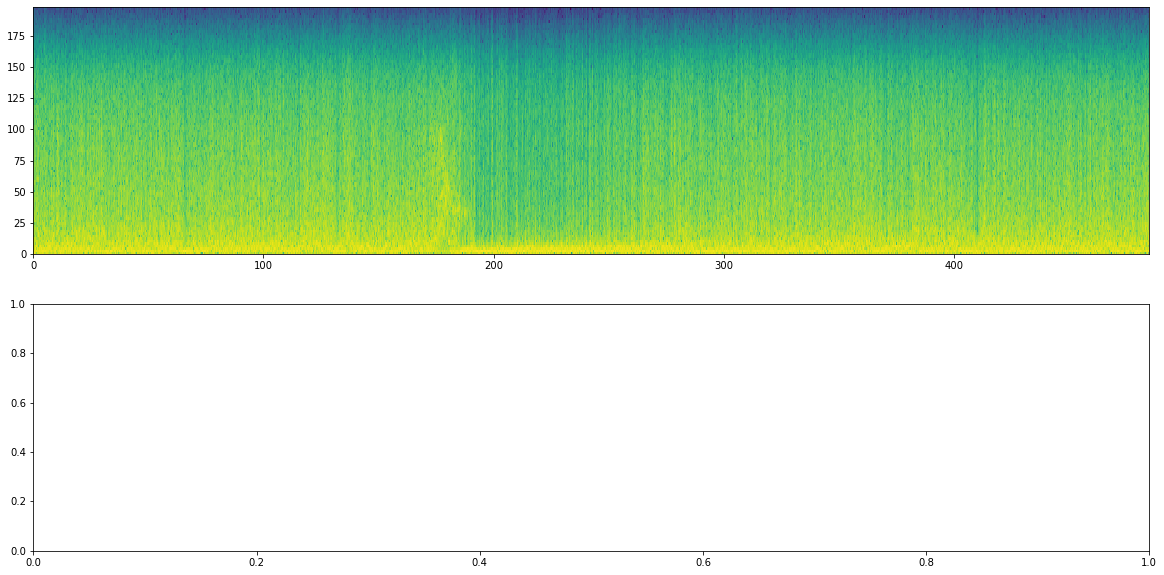

In [132]:
plt.subplots(2,1, figsize=(20,10));
plt.subplot(2,1,1); plt.pcolormesh(t, f, np.log(dtft_norm));
plt.subplot(2,1,2); plt.pcolormesh(t, np.arange(-0.5, nevts+0.5), onehot_encoded.T);  plt.yticks(np.arange(nevts));

## Rough estimate of states

In [133]:
window_size = 30 * (512 // nperseg) # window size in seconds
step_size = 3 * window_size//4 # window overlap

In [134]:
evt_frequency = np.empty((len(np.arange(0, len(evs)-window_size, step_size)), nevs))
start_points = np.arange(0, len(evs)-window_size, step_size)
t_states = np.array([])
for i in range(len(start_points)):
    evt_count = np.array([])
    t_states = np.append(t_states, t[start_points[i] + window_size//2])

    for j in range(nevs):
        evt_count = np.append(evt_count, np.sum(res[start_points[i]:start_points[i]+window_size]==j))
    
    evt_frequency[i,:]=evt_count/np.sum(evt_count)

NameError: name 'evs' is not defined

In [135]:
states_prior = 10
sgm = BayesianGaussianMixture(n_components=states_prior, covariance_type='diag', n_init=10).fit(evt_frequency)
states = sgm.predict(evt_frequency)

NameError: name 'evt_frequency' is not defined

In [136]:
state_ids, state_counts = np.unique(states, return_counts=True)
print("nstates = {}".format(len(state_ids)))
nstates = len(state_ids)

NameError: name 'states' is not defined

In [137]:
for s in state_ids:
    plt.plot(sgm.means_[s,:], 'o-', label=s)
plt.legend()

NameError: name 'state_ids' is not defined

In [138]:
states_encoded = states.reshape(len(states), 1)
onehot_states = onehot_encoder.fit_transform(states_encoded)

NameError: name 'states' is not defined

TypeError: Dimensions of C (6, 3881) are incompatible with X (3881) and/or Y (12); see help(pcolormesh)

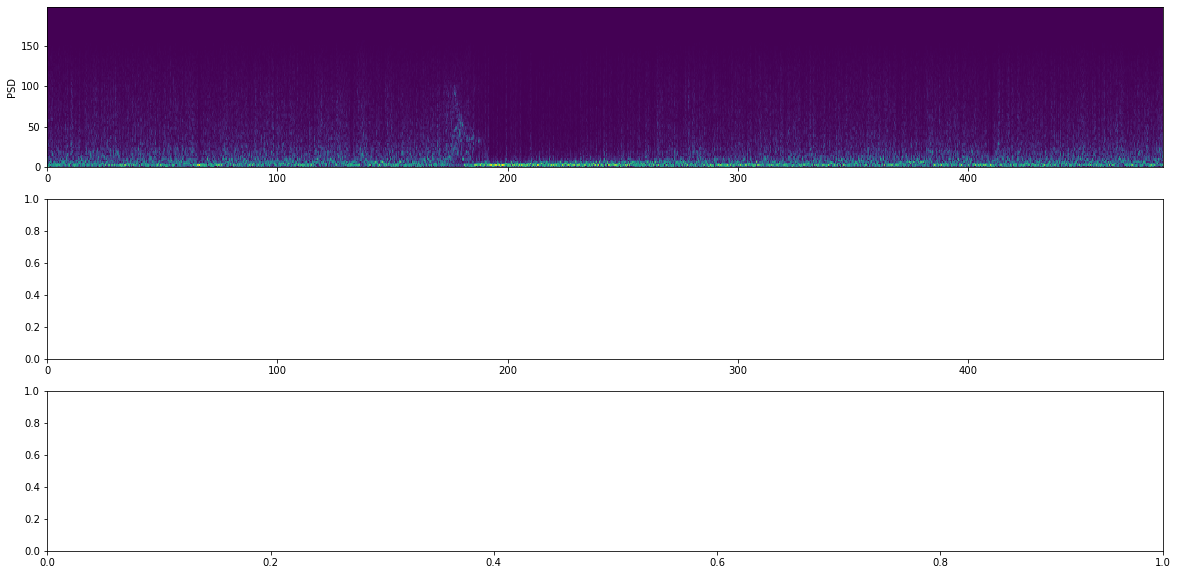

In [139]:
plt.subplots(3,1, figsize=(20,10), sharex='all')
ax = plt.subplot(3,1,1); plt.pcolormesh(t, f, dtft_norm); plt.ylabel('PSD')
plt.subplot(3,1,2, sharex=ax); plt.pcolormesh(t, np.arange(-0.5, nevts + 0.5), onehot_encoded.T);  plt.yticks(np.arange(0, nevts)); plt.ylabel('Events');
plt.subplot(3,1,3, sharex=ax); plt.pcolormesh(t_states, np.arange(-0.5, nstates + 0.5), onehot_states.T);  plt.yticks(np.arange(0, nstates)); plt.ylabel('States');

# Fast ICA

In [ ]:
from sklearn.decomposition import FastICA

In [ ]:
np.shape(data['EEG'])

In [ ]:
x = data['EEG']

In [ ]:
x2 = x.T @ x

In [ ]:
U_ch, D_ch, _ = np.linalg.svd(x2, full_matrices=False)

In [ ]:
plt.scatter(U_ch[:,0], U_ch[:,1], marker='x')

In [ ]:
plt.plot(D_ch, 'o-')